# Importing Dependencies

In [1]:
# Task B2
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os

# Task B3
import plotly.graph_objects as go
import plotly.express as px

# Task B4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,SimpleRNN,LSTM, GRU, Dense, Dropout
import matplotlib.pyplot as plt
import sys

# Task B5
from tensorflow.keras import metrics

C:\Users\THO NGUYEN\AppData\Local\Temp\ipykernel_20544\609613471.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Hyperparameters

In [2]:
# Task B2
TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = "2023-12-31"
LOOK_UP_DAYS = 60      
TRAINING_RATIO = 0.8    # 0.7 == 70%
SCALE_DATA = True
SCALING_METHOD = "MinMax"       # MinMax, Standard

# Task B3
TRADING_PERIOD = 60
CONSECUTIVE_DAYS = 300

# Task B4
NUMBER_OF_LAYER = 1
NUMBER_OF_HIDDEN_UNITS = 80
MODEL_NAME = "RNN"      ## "RNN". "LSTM", "GRU"
DROP_OUT_RATE = 0     ## dropout rate in [0,1]
NUMBER_OF_EPOCHS = 25
BATCH_SIZE = 12
FEATURE_PREDICT = "Close"    ## "Open", "High", "Close", "Low" 
LOSS_FUNCTION = "huber_loss" ## "mean_squared_error", "mean_absolute_error", "huber_loss"
OPTIMIZER = "adam"  ## "adam", "RMSprop", "SGD"

# Task B5
K_SEQUENCE = 20
START_TEST_DATE = "2024-01-01"
END_TEST_DATE = "2024-02-20"

# Task B2: DATA PROCESSING 1

## Scaling dataset

In [3]:
def DataScaler(stock_data, scaling_method=SCALING_METHOD):

    DatasetScaler = None
    ColumnScalers = {

    }
    if scaling_method == "MinMax":
        DatasetScaler = preprocessing.MinMaxScaler()
        
    
    elif scaling_method == "Standard":
        DatasetScaler = preprocessing.StandardScaler()

    
    # Learn the whole dataset
    col_names = stock_data.columns
    features = stock_data[col_names]
    DatasetScaler.fit(features.values)
    features = DatasetScaler.transform(features.values)
    scaledDataFrame = pd.DataFrame(features, columns = col_names)
    scaledDataFrame.index = stock_data.index
    
    for column in col_names:
        column_scaler = None
        if scaling_method == "MinMax":
            column_scaler = preprocessing.MinMaxScaler()
        elif scaling_method == "Standard":
            column_scaler = preprocessing.StandardScaler()
        column_scaler.fit(stock_data[column].values.reshape(-1,1))
        ColumnScalers[column] = column_scaler

    return scaledDataFrame, DatasetScaler, ColumnScalers


## Loading Data Function

In [4]:
def DataLoader(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, scale=SCALE_DATA, scaling_method=SCALING_METHOD):
    '''
    ticker: is the code of the target ticker
    start_date: a start date string with format YYYY/MM/DD
    end_date: an end date string with format YYYY/MM/DD
    scale: a boolean value, True by default
    scaling_method: MinMax(by default), Standard.
    '''

    # result
    result = {
        "dataset": None,
        "datasetScaler": None,
        "columnScalers": None
    }

    # processing the input parameters
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")


    # creating necessary folder
    if not os.path.isdir("results"):
        os.mkdir("results")
    
    if not os.path.isdir("data"):
        os.mkdir("data")


    
    # checking if the data is already downloaded 
    ## Get a list of files in the directory
    files = os.listdir("data")
    ## Check each file in the directory
    data = None
    for file_name in files:
        ## if we already downloaded the ticket data
        if file_name.startswith(ticker) and file_name.endswith(".csv"):
            ### Read the file 
            file_path = os.path.join("data", f"{ticker}.csv")
            data = pd.read_csv(file_path, parse_dates=['Date'])
            break

    ## else, we gonna download the stock data
    if data is None:
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])

    # if the given time is included in the file, we just take the nessecary dataframe
    if data.head(1)["Date"].values[0] <= np.datetime64(start_date) and data.tail(1)["Date"].values[0] >= np.datetime64(end_date):
        data = data[(data['Date'] >= pd.to_datetime(start_date)) & (data['Date'] <= pd.to_datetime(end_date))]
        print("Local Stock Data is enough for requirements, do not need to download")
    else: 
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])
        print("Local Stock Data is not enough for requirements, continuing downloading...")

    # Setting Date as Index
    data.set_index('Date', inplace=True)

    # Scale Data
    if scale:
        data, scaler, column_scalers = DataScaler(data, scaling_method)
        result["dataset"] = data
        result["datasetScaler"] = scaler
        result["columnScalers"] = column_scalers
        return result

    result["dataset"] = data
    
    return result

## Splitting Dataset

In [5]:
def datasetSplitter(dataset: pd.DataFrame, look_up_days=LOOK_UP_DAYS, 
        training_ratio=TRAINING_RATIO,  
        feature_columns=['Open','High','Low','Close','Adj Close','Volume'], k_sequence=K_SEQUENCE):
    '''
    dataset: a Pandas Dataframe
    training_ratio: is equal to TRAINING_RATION constant
    '''
    # result
    splitResult = {
        "X_training_set": None,
        "Y_training_set": None,
    }
  
    # for column in feature_columns:
    #     dataset_in_column = dataset[column].values.reshape(-1, 1)      # <class 'numpy.ndarray'>
    #     x_data = []
    #     y_data = []
    
    #     for x in range(look_up_days, len(dataset_in_column) - k_sequence):
    #         x_data.append(dataset_in_column[x - look_up_days:x, 0])
    #         y_data.append(dataset_in_column[x:x+k_sequence, 0])

    #     splitResult["X_training_set"][column], splitResult["X_testing_set"][column], splitResult["Y_training_set"][column], splitResult['Y_testing_set'][column] = train_test_split(x_data, y_data, test_size=1-training_ratio, shuffle=False)

    #     ## Converting to numpy.array

    #     for column in feature_columns:
    #         splitResult["X_training_set"][column] = np.array(splitResult["X_training_set"][column])
    #         splitResult["Y_training_set"][column] = np.array(splitResult["Y_training_set"][column])
    #         splitResult["X_testing_set"][column] = np.array(splitResult["X_testing_set"][column])
    #         splitResult["Y_testing_set"][column] = np.array(splitResult["Y_testing_set"][column])

    # return splitResult

    x_data = []
    y_data = []
    total_records = len(dataset)
    for day in range(look_up_days, total_records - k_sequence):
        data_points = []
        y_data.append(dataset[FEATURE_PREDICT][day:day+k_sequence])

        for j in range(day - look_up_days, day):
            input_feature_x = []
        
            for column in feature_columns:
                if column == FEATURE_PREDICT:
                    continue
                input_feature_x.append(dataset[column].values.reshape(-1, 1)[j, 0])

            data_points.append(input_feature_x)
        x_data.append(data_points)
    splitResult["X_training_set"], splitResult["Y_training_set"] = x_data, y_data
    
    splitResult["X_training_set"] = np.array(splitResult["X_training_set"])
    splitResult["Y_training_set"] = np.array(splitResult["Y_training_set"])
    
    
    return splitResult


## Data Processing 1 (FULL)

A function to load and process a dataset with multiple features with the following requirements: 

+ Specify the start date and the end date for the whole 
dataset as inputs. 
+ Allowing you to deal with the NaN issue in the data
+ Splitting dataset according to some specified ratio of train/test
+ Storing the downloaded data on your local machine for future uses
+ Allowing you to have an option to scale your feature columns and store the scalers in a data structure to allow future access to these scalers.

In [6]:
def Data_Processing_1():
    dataLoader = DataLoader()

    scaledStockData = dataLoader["dataset"]
    datasetScaler = dataLoader["datasetScaler"]
    columnScalers = dataLoader["columnScalers"]
    
    dataset = datasetSplitter(dataset=scaledStockData)
    
    print("Loaded Done!\nThe result is a tuple as below:\n")
    print("(dataset, scaledStockData, datasetScaler, columnScalers), where:\n")
    print("dataset is a dictionary as below:")
    print('''{
        "X_training_set": <class 'numpy.ndarray'>,
        "Y_training_set": <class 'numpy.ndarray'>,
    }\n''')
    print("scaledStockData is a Pandas Dataframe of the Stock Ticker (scaled)\n")
    print("datasetScaler is the Scaler of the dataset\n")
    print("columnScalers is a dictionary: each key is a DataFrame Feature('Open', 'High', etc.) and the correspond value is a scaler of that feature")
    return dataset, scaledStockData, datasetScaler, columnScalers
    

# Task B5: Machine Learning 2

## Inverse Data

In [7]:
def datasetInverser(scaledStockData, datasetScaler):
    
    # Getting Column name
    col_names = scaledStockData.columns
    # Inversing the dataframe
    re_scaled_features = datasetScaler.inverse_transform(scaledStockData)
    re_scaled_stock_data = pd.DataFrame(re_scaled_features, columns = col_names)
    # Assigning index to the rescaled_data
    re_scaled_stock_data.index = scaledStockData.index


    ## A Pandas Dataframe
    return re_scaled_stock_data
       

## Inversing A Column in the Dataset

In [11]:
def columnInverser(columnData, ColumnScaler):
    '''columnData: an np.array'''
    # transform the shape of the data
    reshaped_data = columnData.reshape(-1, 1)
    result = ColumnScaler.inverse_transform(reshaped_data)
    return result

## Plotting the Loss Error

In [12]:
def trainingErrorPloter(loss, validation):
    fig = plt.figure(figsize=(4, 3)) 
    plt.plot(loss, c="red", label = "training set")
    plt.plot(validation, c="blue", label = "validation set")
    plt.legend()
    plt.title(f"Evaluation on {MODEL_NAME} Model, LOOK_UP_DAYS={LOOK_UP_DAYS}, K_SEQUENCE={K_SEQUENCE}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    return fig

## Plotting Metrics

In [13]:
def MSE_MAE_Ploter(mse, mae):
    fig = plt.figure(figsize=(4, 3)) 
    plt.plot(mse, c="blue", label = f"MSE")
    plt.plot(mae, c="red", label = f"MAE")
    plt.legend()
    plt.title(f"Evaluation on {MODEL_NAME} Model, LOOK_UP_DAYS={LOOK_UP_DAYS}, K_SEQUENCE={K_SEQUENCE}")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    return fig

In [14]:
def R2_Ploter(R2):
    fig = plt.figure(figsize=(4, 3)) 
    plt.plot(R2, c="blue", label = f"R2 Score")
    plt.legend()
    plt.title(f"Evaluation on {MODEL_NAME} Model, LOOK_UP_DAYS={LOOK_UP_DAYS}, K_SEQUENCE={K_SEQUENCE}")
    plt.xlabel("Epochs")
    plt.ylabel("R2 Score")
    return fig

## Result Saver

In [15]:
def resultSaver(trainedModel,errorFig, metrics_MSE_MAE, metrics_R2, modelName=MODEL_NAME):
    ## Get a list of foler in the results folders
    folders = os.listdir("results")

    if modelName not in folders:
        # Create the folder for the model
        folder_path = os.path.join("results", modelName)
        os.makedirs(folder_path)


    # Access the folder model folder and getting model list
    folder_path = os.path.join("results", modelName)
    modelLists = os.listdir(folder_path)
        
    # Creating a new folder to store the training infomation
    latestFolderName = "Model_" + str(len(modelLists))
    model_path = os.path.join(folder_path, latestFolderName)
    os.makedirs(model_path)

    # Saving Fig
    errorFig.savefig(os.path.join(model_path, "error.png"))
    metrics_MSE_MAE.savefig(os.path.join(model_path, "metrics_MSE_MAE.png"))
    metrics_R2.savefig(os.path.join(model_path, "metrics_R2.png"))

    # Saving model summary
    original_stdout = sys.stdout

    with open(os.path.join(model_path, "model_summary.txt"), 'w') as f:
        sys.stdout = f
        trainedModel.summary()

    sys.stdout = original_stdout

    ## Writing nessecary infomation to mode_summary.txt
    with open(os.path.join(model_path, "model_summary.txt"), 'a') as file:
        content = f'''
        NUMBER_OF_LAYER = {NUMBER_OF_LAYER} \n
        NUMBER_OF_HIDDEN_UNITS = {NUMBER_OF_HIDDEN_UNITS} \n
        NUMBER_OF_EPOCHS = {NUMBER_OF_EPOCHS}\n
        BATCH_SIZE = {BATCH_SIZE}\n
        FEATURE_PREDICT = "{FEATURE_PREDICT}"\n    
        LOSS_FUNCTION = "{LOSS_FUNCTION}"\n 
        OPTIMIZER = "{OPTIMIZER}"\n  
        DROP_OUT_RATE = {DROP_OUT_RATE}    '''
        
        file.write(content)
        


## Recurrent Neural Networks (RNNs)

In [16]:
def RecurrentNeuralNetworks(InputLayer,layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=K_SEQUENCE, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(InputLayer)
            model.add(SimpleRNN(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(SimpleRNN(hidden_units, activation=activation[0], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), metrics.R2Score()], optimizer=optimizerType)
    return model

## Long Short Term Memory (LSTM)

In [17]:
def LongShortTermMemory(InputLayer, layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=K_SEQUENCE, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(InputLayer)
            model.add(LSTM(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(LSTM(hidden_units, activation=activation[0], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), metrics.R2Score()], optimizer=optimizerType)
    return model

## Gated Recurrent Unit (GRU)

In [18]:
def GatedRucurrentUnit(InputLayer, layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=K_SEQUENCE, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(InputLayer)
            model.add(GRU(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(GRU(hidden_units, activation=activation[0], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), metrics.R2Score()], optimizer=optimizerType)
    return model

## Testing Data Loader

In [ ]:
def testingDataLoader(ticker=TICKER, start_date=START_TEST_DATE, end_date=END_TEST_DATE, scale=SCALE_DATA, scaling_method=SCALING_METHOD, k_days=K_SEQUENCE, feature=FEATURE_PREDICT):
    result = {
        "x_scaled_test": None,
        "y_scaled_test": None,
        "x_orginal_test": None,
        "y_original_test": None
    }
    
    stock_data = yf.download(ticker, start_date, end_date)
    stock_data = stock_data.set_index('Date')
    # Getting k_days records from the first record
    stock_data = stock_data.head(k_days)

    
    ### Multiple feature!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Scale Data
    if scale:
        scaledData, scaler, column_scalers = DataScaler(stock_data, scaling_method)
        result[""]
        return ()
        
    
    

## Training Function

In [19]:
def Train(model, dataset, column_scalers, scaled=SCALE_DATA, num_epoc=NUMBER_OF_EPOCHS, batch=BATCH_SIZE, feature=FEATURE_PREDICT):
    

    ## Getting x_train, y_train, x_test, and y_test
    x_train = dataset["X_training_set"]
    y_train = dataset["Y_training_set"]


    ## Training 
    training_result = model.fit(x_train, y_train, epochs=num_epoc, batch_size=batch, validation_split=0.2)

    ## Plotting the error
    errorfig = trainingErrorPloter(training_result.history["loss"], training_result.history["val_loss"])
    
    ## Testing the result
    
    ### performing prediction
    predicted_y_test = model.predict(x_test)
    ### Inversing the data if required
    if scaled:
        y_test = columnInverser(y_test, column_scalers[feature])
        predicted_y_test = columnInverser(predicted_y_test, column_scalers[feature])

    ## Ploting the evaluation Result
    MSE_MAE_Fig = MSE_MAE_Ploter(training_result.history["mean_squared_error"], training_result.history["mean_absolute_error"])
    R2_Fig = R2_Ploter(training_result.history["r2_score"])
    resultSaver(model, errorfig, MSE_MAE_Fig, R2_Fig)


In [20]:
dataset, scaledStockData, datasetScaler, ColumnScalers  = Data_Processing_1()

d:\DELL\Desktop\COS30018\COS30018\ProjectAssessment\TaskB1\myenv\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Local Stock Data is not enough for requirements, continuing downloading...
Loaded Done!
The result is a tuple as below:

(dataset, scaledStockData, datasetScaler, columnScalers), where:

dataset is a dictionary as below:
{
        "X_training_set": <class 'numpy.ndarray'>,
        "Y_training_set": <class 'numpy.ndarray'>,
        "X_testing_set": <class 'numpy.ndarray'>,
        "Y_testing_set": <class 'numpy.ndarray'>
    }

scaledStockData is a Pandas Dataframe of the Stock Ticker (scaled)

datasetScaler is the Scaler of the dataset

columnScalers is a dictionary: each key is a DataFrame Feature('Open', 'High', etc.) and the correspond value is a scaler of that feature


# Task B5: Machine Learning 2 (FULL)

In [21]:
def Machine_Learning_2(dataset=dataset, column_scalers=ColumnScalers,modelName=MODEL_NAME):
    model = None
    inputLayer = Input(shape=(dataset["X_training_set"].shape[1],dataset["X_training_set"].shape[2]))
    if modelName == "RNN":
        model = RecurrentNeuralNetworks(inputLayer)
    elif modelName == "LSTM":
    #     ## TO DO
        model = LongShortTermMemory(inputLayer)
    elif modelName == "GRU":
        model = GatedRucurrentUnit(inputLayer)

    ## Performing Training and getting result
    Train(model, dataset, column_scalers)



Epoch 1/25

  1/184 [..............................] - ETA: 3:49 - loss: 0.0288 - mean_squared_error: 0.0576 - mean_absolute_error: 0.1931 - r2_score: -12.6027

184/184 [==============================] - 3s 9ms/step - loss: 9.7692e-04 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0257 - r2_score: 0.4562 - val_loss: 0.0065 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0769 - val_r2_score: 0.4883
Epoch 2/25
184/184 [==============================] - 1s 7ms/step - loss: 1.0196e-04 - mean_squared_error: 2.0392e-04 - mean_absolute_error: 0.0106 - r2_score: 0.9432 - val_loss: 0.0046 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0688 - val_r2_score: 0.6372
Epoch 3/25
184/184 [==============================] - 1s 7ms/step - loss: 6.3639e-05 - mean_squared_error: 1.2728e-04 - mean_absolute_error: 0.0085 - r2_score: 0.9646 - val_loss: 0.0028 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0517 - val_r2_score: 0.7783
Epoch 4/25
184/184 [==============================] - 1s 6ms/step - loss: 5.0625e-05 - mean_squared_error: 1.0125e-04 - mean_absolute_error: 0.0075 - r2_score: 0.9718 - val_loss: 0.0024 -

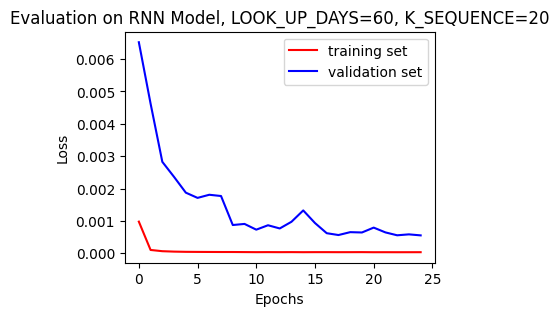

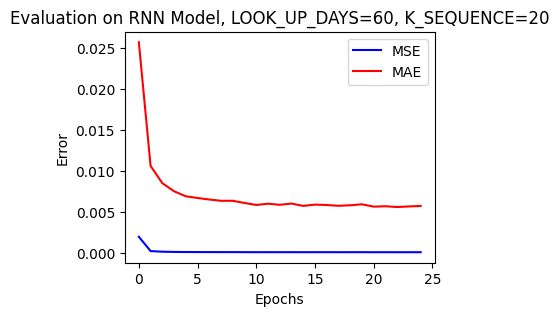

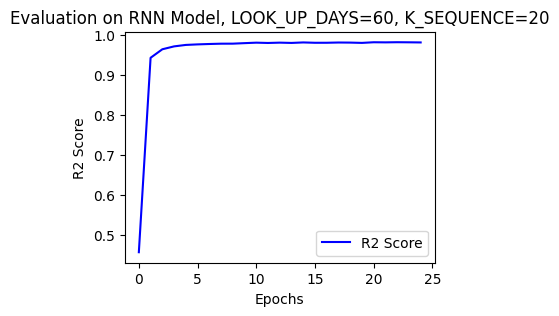

In [22]:
Machine_Learning_2()

# Prediting

In [24]:
x_test = dataset["X_testing_set"]
y_test = dataset["Y_testing_set"]
print(x_test.shape)
print(y_test.shape)

(689, 60, 5)
(689, 20)
